Hi there,

In this file, you are going to load 2 files: applications.csv and questions.csv, generate some descriptive analysis.

Now, first step, please import libraries you think you will need. You will need some libraries to process tables, create bar charts, etc. You will be asked to create a logistics regression model at Question 6. You can always import libraries when needed.

In [1]:
import pandas as pd
import seaborn as sns
import os 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Read csv files : applications.csv as "applications" and questions.csv as "questions".

In [2]:
applications = pd.read_csv('applications.csv')
questions = pd.read_csv('questions.csv')

Please get some sense from the 2 tables you just loaded. You can use any functions as your prefer. You might want to know what columns are in the tables, what are their types, how big are the dataset, even some records for you to grasp the idea.

In [3]:
print(applications.shape)
print(applications.dtypes)
print(applications.head(5))

(2000, 3)
applicant_id              object
application_created_at    object
submitted_at              object
dtype: object
  applicant_id application_created_at submitted_at
0   6889992485             2017-09-20   2017-09-20
1   9661824773             2017-08-30          NaN
2  10901109380             2017-09-17          NaN
3   4654038743             2017-08-29   2017-08-29
4  10334260734             2017-08-13          NaN


In [4]:
print(questions.shape)
print(questions.dtypes)
print(questions.head(5))

(3966, 3)
applicant_id    object
question        object
response        object
dtype: object
  applicant_id   question                         response
0   6730769363  education                Bachelor's degree
1  10921465866    purpose                              NaN
2  10770974651    purpose  Grow skills for my current role
3  10807426036  education                            Other
4  10339949523  education                  Master's degree


As you notice, there is a columns shared in both tables. You are right, it's the primiary key. You might want to use this information to join the tables.
Also, if there's no values, for example, if there's no value in "submitted_at" that means the applicant started an application but didn't submit it. Or if there's no value under "response", that means the applicant didn't give a response.

Now, here comes the first questions.
Question1. How many applicant submitted their application? How many didn't?
(suggestions: create a new column called "submitted" with values 1 (submitted) and 0 (didn't submit))

In [5]:
applications['application_created_at'] = pd.to_datetime(applications.application_created_at)
applications['submitted_at'] = pd.to_datetime(applications.submitted_at)
applications['submitted'] = np.where(applications['submitted_at'].isnull(), 0, 1)
applications.groupby('submitted').agg({'applicant_id': lambda x: len(set(x))}).reset_index()

,submitted,applicant_id
0,0,500
1,1,1500


Questions2. What’s the frequency distribution of applicants by different
    a. education
    b. purpose
    c. combination of education and purpose
(please there's no values in "response", please use "No Reponse")
(suggestion: the output table after joining will be better to look like: applicant_id, application_created_at, submitted_at, education, purpose)

In [6]:
# join tables - method 1, but hard to do c
df = pd.merge(applications,questions,on='applicant_id')
df['response_'] = np.where(df['response'].isnull(),'No Response',df['response'])
df.head()

,applicant_id,application_created_at,submitted_at,submitted,question,response,response_
0,6889992485,2017-09-20,2017-09-20,1,education,Bachelor's degree,Bachelor's degree
1,6889992485,2017-09-20,2017-09-20,1,purpose,Help move from academia to industry,Help move from academia to industry
2,9661824773,2017-08-30,NaT,0,purpose,NaN,No Response
3,9661824773,2017-08-30,NaT,0,education,NaN,No Response
4,10901109380,2017-09-17,NaT,0,purpose,NaN,No Response


In [7]:
#education
educations = questions.loc[questions['question']=='education'].reset_index()
educations['education'] = np.where(educations['response'].isnull(),'No Response',educations['response'])
educations.columns = ['index','applicant_id','question','response','education']
educations = educations.loc[:,('applicant_id','education')]
#purpose
purposes = questions.loc[questions['question']=='purpose'].reset_index()
purposes['purpose'] = np.where(purposes['response'].isnull(),'No Response',purposes['response'])
purposes.columns = ['index','applicant_id','question','response','purpose']
purposes = purposes.loc[:,('applicant_id','purpose')]
#join
questions_ = pd.merge(educations,purposes,on='applicant_id')
df = pd.merge(applications,questions_,how='left',on='applicant_id')
df.head()

,applicant_id,application_created_at,submitted_at,submitted,education,purpose
0,6889992485,2017-09-20,2017-09-20,1,Bachelor's degree,Help move from academia to industry
1,9661824773,2017-08-30,NaT,0,No Response,No Response
2,10901109380,2017-09-17,NaT,0,No Response,No Response
3,4654038743,2017-08-29,2017-08-29,1,Master's degree,General interest in the topic (personal growth...
4,10334260734,2017-08-13,NaT,0,No Response,No Response


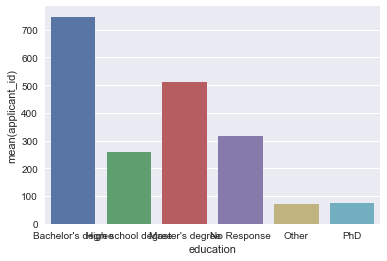

In [8]:
# education
sns.barplot(data=df.groupby('education').agg({'applicant_id':lambda x:len(set(x))}).reset_index(),
            x='education',y='applicant_id')

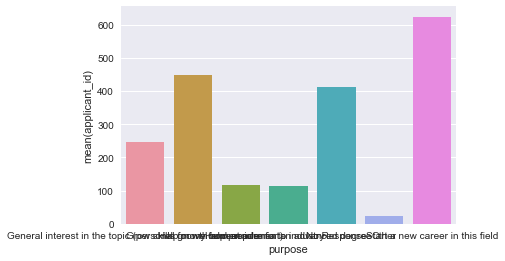

In [9]:
# purpose
sns.barplot(data=df.groupby('purpose').agg({'applicant_id':lambda x:len(set(x))}).reset_index(),
            x='purpose',y='applicant_id')

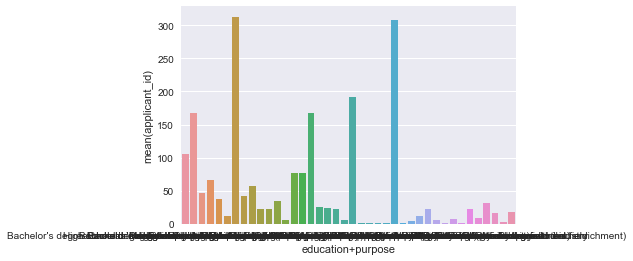

In [10]:
# combination of education and purpose
c = df.groupby(['education', 'purpose']).agg({'applicant_id': lambda x: len(set(x))}).reset_index()
c['education+purpose'] = c['education']+c['purpose']
sns.barplot(data=c, x='education+purpose', y='applicant_id')

Question3. What's the min and max of application_created_at in applications?

In [11]:
print(applications['application_created_at'].min())
print(applications['application_created_at'].max())

2017-06-20 00:00:00
2017-09-27 00:00:00


Question4. For those applicants submitted their applications, let’s build a table, and generate a heatmap - For applicants who applied on Jun 20 2017, what proportion of them submit the application in the 1st week (Jun 21 – Jun 27 2016), in the 2nd week (Jun 28 – Jul 4 2016), in the 3rd week (Jul 5 – Jun 11 2017) etc. all the way upto 6 weeks. Calculate averagely, % of application submition in each week, then create a heatmap.

In [12]:
df_ = df.loc[df['submitted']==1]
df_['weeks_between'] = df_.submitted_at - df_.application_created_at
df_['weeks_between'] = np.ceil(df_.weeks_between.dt.days/7)
df_.head()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,applicant_id,application_created_at,submitted_at,submitted,education,purpose,weeks_between
0,6889992485,2017-09-20,2017-09-20,1,Bachelor's degree,Help move from academia to industry,0.0
3,4654038743,2017-08-29,2017-08-29,1,Master's degree,General interest in the topic (personal growth...,0.0
6,10756434754,2017-07-11,2017-07-11,1,Master's degree,Start a new career in this field,0.0
7,6772779398,2017-07-25,2017-07-25,1,Master's degree,General interest in the topic (personal growth...,0.0
11,4660478614,2017-07-25,2017-07-25,1,Master's degree,Start a new career in this field,0.0


In [13]:
df_ = df_.query('weeks_between <= 6')

In [14]:
df_2 = df_.groupby(['application_created_at', 'weeks_between']).agg({'applicant_id': lambda x: len(set(x))}).reset_index()

df_2 = df_2.pivot_table(index='application_created_at', columns='weeks_between', aggfunc=lambda x: x).fillna(0)
df_2.columns = df_2.columns.droplevel(0)

In [15]:
df_apply = df_.groupby(['application_created_at']).agg({'applicant_id':lambda x: x.nunique()})

In [16]:
df_3 = pd.concat([df_apply, df_2], axis=1).apply(lambda x: x/x['applicant_id'], axis=1).drop('applicant_id', axis=1)
df_3.columns = ['% submit in {}th week'.format(int(i)) for i in df_3.columns]
df_3 = pd.concat([df_apply.rename(columns={'applicant_id': '# apply'}), df_3], axis=1)
df_3.head(10)

,# apply,% submit in 0th week,% submit in 1th week,% submit in 2th week,% submit in 3th week,% submit in 4th week,% submit in 5th week,% submit in 6th week
application_created_at,,,,,,,,
2017-06-20,10,0.500000,0.100000,0.000000,0.200000,0.100000,0.000000,0.100000
2017-06-21,21,0.857143,0.000000,0.000000,0.047619,0.000000,0.047619,0.047619
2017-06-22,17,0.588235,0.176471,0.000000,0.058824,0.058824,0.058824,0.058824
2017-06-23,21,0.619048,0.095238,0.000000,0.000000,0.190476,0.047619,0.047619
2017-06-24,7,0.714286,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857
2017-06-25,13,0.615385,0.230769,0.000000,0.076923,0.076923,0.000000,0.000000
2017-06-26,11,0.727273,0.090909,0.090909,0.000000,0.000000,0.090909,0.000000
2017-06-27,12,0.750000,0.000000,0.083333,0.083333,0.000000,0.083333,0.000000
2017-06-28,16,0.625000,0.062500,0.000000,0.062500,0.000000,0.250000,0.000000


In [17]:
df_3.mean(axis = 0)

# apply                 14.960000
% submit in 0th week     0.790215
% submit in 1th week     0.114520
% submit in 2th week     0.028895
% submit in 3th week     0.027098
% submit in 4th week     0.015941
% submit in 5th week     0.015441
% submit in 6th week     0.007890
dtype: float64

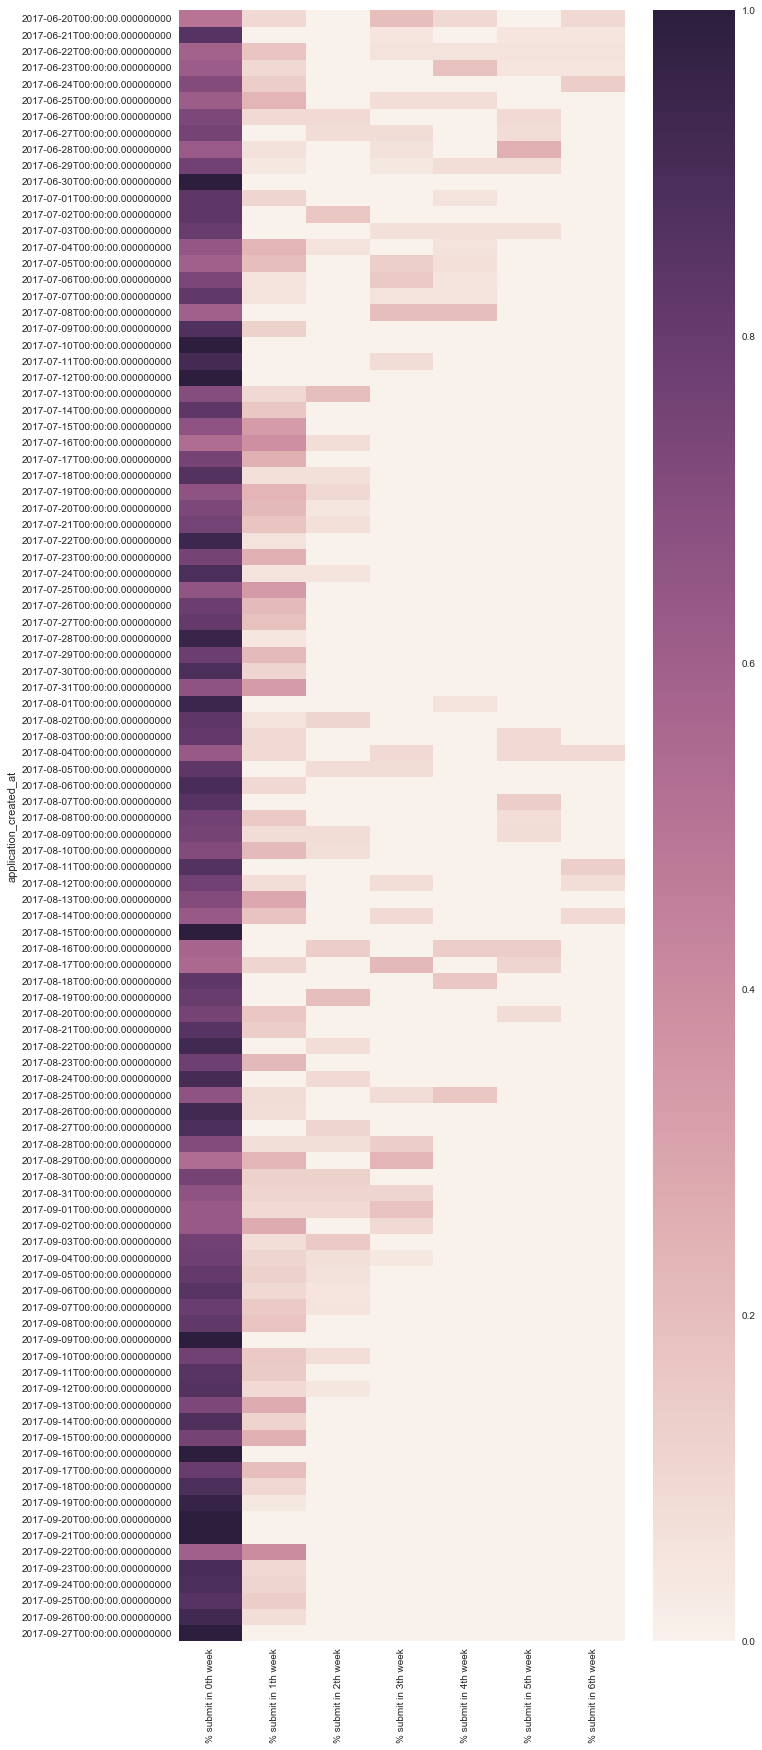

In [18]:
fig, ax = plt.subplots(figsize=(10, 30))
sns.heatmap(df_3.iloc[:, range(1, df_3.shape[1])])

Question5. Similar to the table you created in Q4, what if we were to build it for just two days – 27th June 2017 and 19th Sep 2017, but segmented by education? Depict this graphically. Does the submition vary by different education?

In [19]:
df_5 = df.query('application_created_at=="2017-06-27" | application_created_at== "2017-09-19"').copy()
df_5.application_created_at.value_counts()

2017-09-19    33
2017-06-27    16
Name: application_created_at, dtype: int64

In [24]:
# calculate weeks between apply and submit
df_5['weeks_between'] = df_5.submitted_at - df_5.application_created_at
df_5['weeks_between'] = np.ceil(df_5.weeks_between.dt.days/7)

In [25]:
df_5_2 = df_5.groupby(['application_created_at','education','weeks_between']).agg({'applicant_id': lambda x: len(set(x))}).reset_index()

df_5_2 = df_5_2.pivot_table(index=['application_created_at','education'], columns='weeks_between', aggfunc=lambda x: x).fillna(0)
df_5_2.columns = df_5_2.columns.droplevel(0)

In [26]:
df_5_apply = df_5.groupby(['application_created_at','education']).agg({'applicant_id':lambda x: x.nunique()})

In [27]:
df_5_3 = pd.concat([df_5_apply, df_5_2], axis=1).apply(lambda x: x/x['applicant_id'], axis=1).drop('applicant_id', axis=1)
df_5_3.columns = ['% submit in {}th week'.format(int(i)) for i in df_5_3.columns]
df_5_3 = pd.concat([df_5_apply.rename(columns={'applicant_id': '# apply'}), df_5_3], axis=1)
df_5_3.head(10)

# apply  % submit in 0th week  \
application_created_at education                                           
2017-06-27             Bachelor's degree         6              0.833333   
                       High school degree        1              1.000000   
                       Master's degree           6              0.333333   
                       No Response               2                   NaN   
                       Other                     1              1.000000   
2017-09-19             Bachelor's degree        13              0.923077   
                       High school degree        7              0.857143   
                       Master's degree           8              0.875000   
                       No Response               3                   NaN   
                       PhD                       2              1.000000   

                                           % submit in 1th week  \
application_created_at education                                  
2017-06-27             Bachelor's degree                  0.000   
                       High school degree                 0.000   
                       Master's degree                    0.000   
                       No Response                          NaN   
                       Other                              0.000   
2017-09-19             Bachelor's degree                  0.000   
                       High school degree                 0.000   
                       Master's degree                    0.125   
                       No Response                          NaN   
                       PhD                                0.000   

                                           % submit in 2th week  \
application_created_at education                                  
2017-06-27             Bachelor's degree               0.000000   
                       High school degree              0.000000   
                       Master's degree                 0.166667   
                       No Response                          NaN   
                       Other                           0.000000   
2017-09-19             Bachelor's degree               0.000000   
                       High school degree              0.000000   
                       Master's degree                 0.000000   
                       No Response                          NaN   
                       PhD                             0.000000   

                                           % submit in 3th week  \
application_created_at education                                  
2017-06-27             Bachelor's degree               0.000000   
                       High school degree              0.000000   
                       Master's degree                 0.166667   
                       No Response                          NaN   
                       Other                           0.000000   
2017-09-19             Bachelor's degree               0.000000   
                       High school degree              0.000000   
                       Master's degree                 0.000000   
                       No Response                          NaN   
                       PhD                             0.000000   

                                           % submit in 5th week  
application_created_at education                                 
2017-06-27             Bachelor's degree               0.166667  
                       High school degree              0.000000  
                       Master's degree                 0.000000  
                       No Response                          NaN  
                       Other                           0.000000  
2017-09-19             Bachelor's degree               0.000000  
                       High school degree              0.000000  
                       Master's degree                 0.000000  
                       No Response                     

Question6. In Question1, you created a column called "submitted" (1/0), now use "education" and "purpose" to create a logistics regression model to predict "submitted". Please exclude "No Response" and "Other" in the model. Are "education" or "purpose" affecting "submitted"? What's your suggestion?

In [28]:
import statsmodels.api as sm

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [29]:
education_dummies = pd.get_dummies(df.education)
purpose_dummies = pd.get_dummies(df.purpose)
data = pd.concat([df.submitted,education_dummies,purpose_dummies],axis=1)

In [30]:
train_cols = ["Bachelor's degree","High school degree","Master's degree","PhD"
              ,"General interest in the topic (personal growth and enrichment)","Grow skills for my current role"
              ,"Help move from academia to industry","Help prepare for an advanced degree"
              ,"Start a new career in this field"]
logit = sm.Logit(data['submitted'],data[train_cols])

In [31]:
logit.fit().summary()

Optimization terminated successfully.
         Current function value: 0.305477
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              submitted   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1991
Method:                           MLE   Df Model:                            8
Date:                Thu, 28 Sep 2017   Pseudo R-squ.:                  0.4568
Time:                        14:45:03   Log-Likelihood:                -610.95
converged:                       True   LL-Null:                       -1124.7
                                        LLR p-value:                1.787e-216
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
Bachelor's degree                                                 -1.1579      0.238     -4.874      0.000      -1.624      -0.692
High school degree                                                -1.1547      0.269     -4.301      0.000      -1.681      -0.628
Master's degree                                                   -0.6247      0.268     -2.327      0.020      -1.151      -0.098
PhD                                                               -0.9503      0.559     -1.699      0.089      -2.046       0.146
General interest in the topic (personal growth and enrichment)     3.4971      0.317     11.038      0.000       2.876       4.118
Grow skills for my current role                                    4.1568      0.320     12.973      0.000       3.529       4.785
Help move from academia to industry                                4.0909      0.503      8.132      0.000       3.105       5.077
Help prepare for an advanced degree                                4.6627      0.621      7.508      0.000       3.446       5.880
Start a new career in this field                                   3.7141      0.265     14.037      0.000       3.196       4.233
==================================================================================================================================
"""